In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from distfit import distfit
import re
from sympy import symbols, simplify, sin, cos, log, Abs, exp, expand_power_base, Mul, Rational, sqrt
from sympy.parsing.sympy_parser import parse_expr
import seaborn as sns
import copy
import json
from ydata_profiling import ProfileReport
import sys
import os
import bnlearn as bn

# Add the directory containing 'thesis_utils.py' to the system path
sys.path.append(os.path.abspath('..'))  # If 'thesis_utils.py' is one level up
# Or use this if it's in the same directory as the notebook:
# sys.path.append(os.getcwd())

from thesis_utils import *

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [49]:
import importlib
import thesis_utils  # or whatever your module is called

importlib.reload(thesis_utils)

from thesis_utils import *

In [10]:
data = pd.read_csv('C:/Users/svenl/vs_code_projects/hyperRealDataDescriber/data/credit_score/cleaned_credit_score_v2.csv')
data = data.drop(['ID', 'Customer_ID', 'Name', 'SSN', 'Type_of_Loan', 'Payment_Behaviour'], axis=1)

In [11]:
data, rename_map = anonymize_column_names(data)
data_reduced = data.drop('X8', axis=1)

In [14]:
# Generate the profiling report
profile = ProfileReport(data_reduced, title="Credit Score Cleaned and Anonymized", explorative=True)

# Get the description object
desc = profile.get_description()

# Access the correlation matrix
correlation_matrix = desc.correlations["auto"]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

In [13]:
expression_str_raw = "((abs((log(x5) * sin(sin(0.88440996 - log(x5)) / 0.40294483)) - x3) + (x2 + sqrt(abs(x1)))) - (sqrt(x4) * -2.525663)) * 0.5136726"
num_independent_vars = 5

def generate_var_string(num_independent_vars):
    var_string = ''
    for i in range(num_independent_vars):
        var_string = var_string + ('x' + str(i) + ' ')
    return var_string[0:len(var_string) - 1]

variables = generate_var_string(2)

exec(f"{', '.join(variables.split())} = symbols('{variables}')")

parsed_expr = parse_expr(expression_str_raw)
expr = simplify(parsed_expr)
print(expr)

0.5136726*x2 + 1.2973638799338*sqrt(x4) + 0.5136726*sqrt(Abs(x1)) + 0.5136726*Abs(x3 + log(x5)*sin(2.48172932259734*sin(log(x5) - 0.88440996)))


In [15]:
# define variables to use in expression
x1_ = data_reduced['X10'].to_numpy()  # 'Delay_from_due_date'
x2_ = data_reduced['X6'].to_numpy()  # 'Num_Bank_Accounts'
x3_ = data_reduced['X13'].to_numpy()  # 'Num_Credit_Inquiries'
x4_ = data_reduced['X11'].to_numpy()  # 'Num_of_Delayed_Payment'
x5_ = data_reduced['X15'].to_numpy()  # 'Outstanding_Debt'

X8_interest_rate_predicted = 0.5136726*x2_ + 1.2973638799338*np.sqrt(x4_) + 0.5136726*np.sqrt(np.abs(x1_)) + 0.5136726*np.abs(x3_ + np.log(x5_)*np.sin(2.48172932259734*np.sin(np.log(x5_) - 0.88440996)))

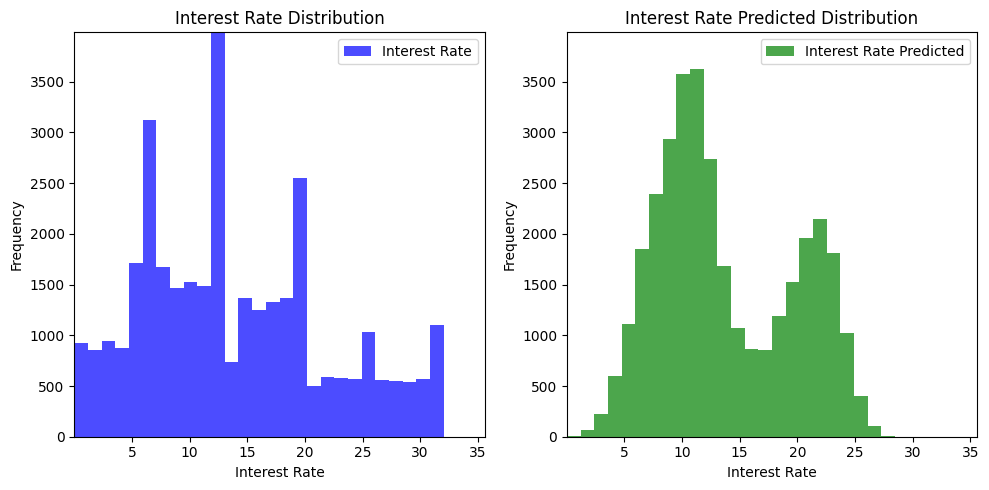

In [16]:
%matplotlib inline
plot_histograms([(data["X8"], "Interest Rate", "blue"), (X8_interest_rate_predicted, "Interest Rate Predicted", "green")], xlabel="Interest Rate")

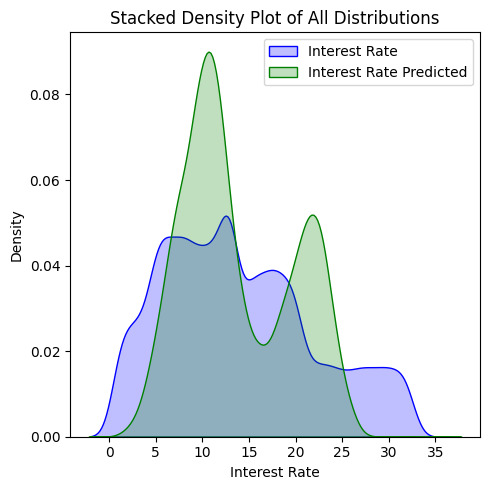

In [17]:
%matplotlib inline
plot_densities([(data["X8"], "Interest Rate", "blue"), (X8_interest_rate_predicted, "Interest Rate Predicted", "green")], xlabel="Interest Rate", stack=True)

In [18]:
X8_interest_rate_corrected = correct_sr_inference(data, ["X10", "X6", "X13", "X11", "X15"], "X8", pd.Series(X8_interest_rate_predicted))

XGBoost Residual Correction Test MSE: 18.6995
Final MSE after XGBoost residual correction: 4.5133


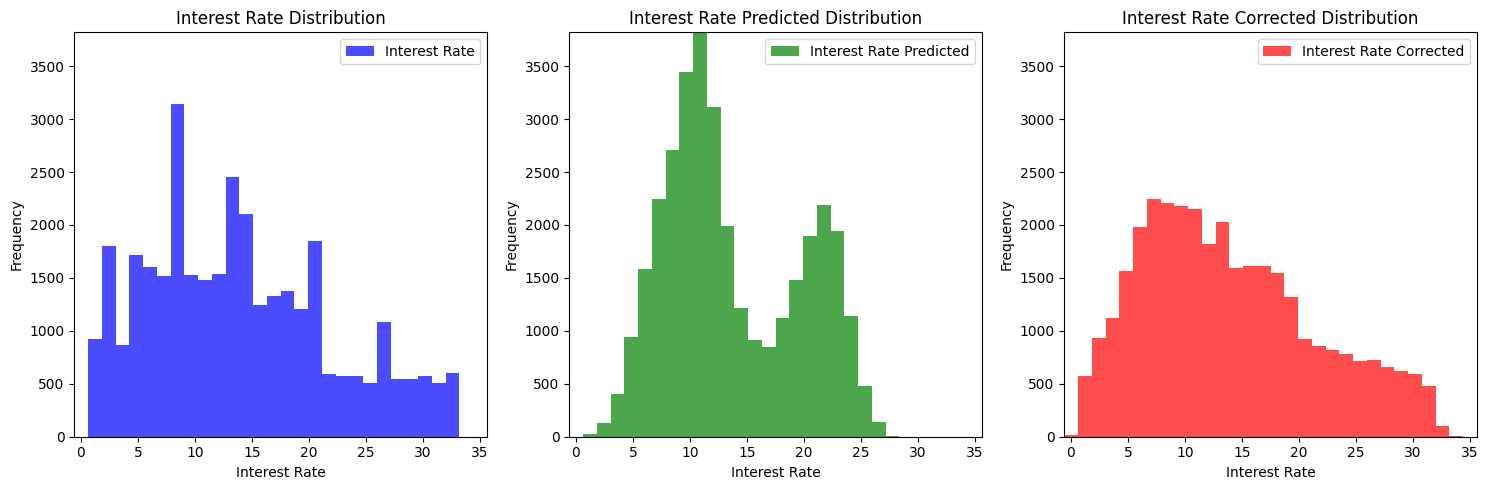

In [19]:
%matplotlib inline
plot_histograms([(data["X8"], "Interest Rate", "blue"), (X8_interest_rate_predicted, "Interest Rate Predicted", "green"), (X8_interest_rate_corrected, "Interest Rate Corrected", "red")], xlabel="Interest Rate")

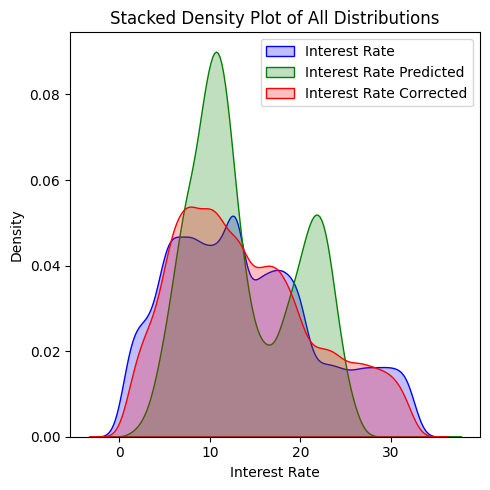

In [20]:
%matplotlib inline
plot_densities([(data["X8"], "Interest Rate", "blue"), (X8_interest_rate_predicted, "Interest Rate Predicted", "green"), (X8_interest_rate_corrected, "Interest Rate Corrected", "red")], xlabel="Interest Rate", stack=True)

In [36]:
distributions = fit_distributions(data_reduced)
distributions.items()

dict_items([('X2', {'best_distribution': 0, 'parameters': {'name': 'gamma', 'score': 0.009541292946341347, 'loc': -36.80733325760838, 'scale': 1.5181323583287671, 'arg': (46.531195523890574,), 'params': (46.531195523890574, -36.80733325760838, 1.5181323583287671), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000145BFF32410>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c'}}), ('X4', {'best_distribution': 0, 'parameters': {'name': 'lognorm', 'score': 1.11038288336347e-09, 'loc': 5792.878182974476, 'scale': 30735.023755884537, 'arg': (1.140174436491074,), 'params': (1.140174436491074, 5792.878182974476, 30735.023755884537), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000145BC11AF90>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c'}}), ('X5', {'best_distribution': 0, 'parameters': {'name': 'lognorm', 'score': 5.341720690638148e-07, 'loc': -66.54396687723208, 'scale': 3191.8198659829054, 

In [42]:
result = distributions['X2'].items()
print(result)

dict_items([('best_distribution', 0), ('parameters', {'name': 'gamma', 'score': 0.009541292946341347, 'loc': -36.80733325760838, 'scale': 1.5181323583287671, 'arg': (46.531195523890574,), 'params': (46.531195523890574, -36.80733325760838, 1.5181323583287671), 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000145BFF32410>, 'bootstrap_score': 0, 'bootstrap_pass': None, 'color': '#e41a1c'})])


In [21]:
# Suppose 'df' is your original DataFrame, and you want to drop the 'X6 price' column:
df_preprocessed = auto_preprocess_bn(data_reduced, discrete_threshold=15)

# Fit the Bayesian network using bnlearn with the preprocessed DataFrame
model = bn.structure_learning.fit(df_preprocessed, methodtype='hc', scoretype='bic')
print(model['model_edges'])

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[('X4', 'X5'), ('X4', 'X19'), ('X6', 'X10'), ('X6', 'X11'), ('X9', 'X19'), ('X9', 'X21'), ('X13', 'X17'), ('X13', 'X2'), ('X13', 'X1'), ('X14', 'X6'), ('X14', 'X10'), ('X14', 'X15'), ('X14', 'X11'), ('X14', 'X9'), ('X14', 'X13'), ('X14', 'X17'), ('X14', 'X7'), ('X14', 'X12'), ('X14', 'X4'), ('X14', 'X20'), ('X14', 'X21'), ('X15', 'X12'), ('X15', 'X7'), ('X17', 'X9'), ('X17', 'X15'), ('X18', 'X14'), ('X18', 'X12'), ('X18', 'X13'), ('X18', 'X2'), ('X20', 'X4'), ('X21', 'X4'), ('X21', 'X5'), ('X21', 'X16'), ('X21', 'X20')]


In [29]:
categorical_cols = get_categorical_columns(data_reduced)

In [30]:
bayesian_profile = generate_bn_generation_profile(data_reduced, categorical_cols, model['model_edges'], distributions)
print(json.dumps(bayesian_profile, indent=4, default=lambda x: float(x)))

{
    "variables": {
        "X1": {
            "type": "categorical",
            "levels": [
                "September",
                "November",
                "December",
                "October"
            ],
            "marginal": {
                "September": 0.2529835055820427,
                "November": 0.2506736948088484,
                "December": 0.2501110485948651,
                "October": 0.24623175101424383
            },
            "conditional": {
                "parents": [
                    "X13"
                ],
                "table": {
                    "X13=[0.0, 4.0)": {
                        "September": 0.3063967335828513,
                        "October": 0.2633548826131337,
                        "November": 0.23358285130996936,
                        "December": 0.1966655324940456
                    },
                    "X13=[4.0, 6.0)": {
                        "December": 0.25944543538187126,
                        "Octobe

In [50]:
get_distribution_statements(distributions, data_reduced)

['Column "X1": type = categorical, categories = ["September", "October", "November", "December"]',
 'Column "X2": type = numerical, distribution = gamma, alpha = 46.531, theta = 1.518, range = 14 to 56 (with only whole numbers allowed)',
 'Column "X3": type = categorical, categories = ["Scientist", "Teacher", "Engineer", "Entrepreneur", "Developer", "Lawyer", "Media_Manager", "Doctor", "Journalist", "Manager", "Accountant", "Musician", "Mechanic", "Writer", "Architect"]',
 'Column "X4": type = numerical, distribution = lognorm, mean = 10.333, deviation = 1.14, range = 7005.93 to 24137255.0',
 'Column "X5": type = numerical, distribution = lognorm, mean = 8.068, deviation = 0.715, range = 303.65 to 15204.63',
 'Column "X6": type = numerical, distribution = gaussian, mean = 5.388, deviation = 2.573, range = 0 to 11 (with only whole numbers allowed)',
 'Column "X7": type = numerical, distribution = gamma, alpha = 42.888, theta = 0.314, range = 0 to 11 (with only whole numbers allowed)',
 

In [33]:
get_correlation_statements(correlation_matrix)

['Columns X10 and X11 (r = 0.52)',
 'Columns X10 and X12 (r = 0.27)',
 'Columns X10 and X13 (r = 0.5)',
 'Columns X10 and X14 (r = 0.58)',
 'Columns X10 and X15 (r = 0.51)',
 'Columns X10 and X17 (r = -0.46)',
 'Columns X10 and X18 (r = 0.36)',
 'Columns X10 and X21 (r = -0.31)',
 'Columns X10 and X4 (r = -0.23)',
 'Columns X10 and X5 (r = -0.21)',
 'Columns X10 and X6 (r = 0.56)',
 'Columns X10 and X7 (r = 0.43)',
 'Columns X10 and X9 (r = 0.42)',
 'Columns X11 and X12 (r = 0.27)',
 'Columns X11 and X13 (r = 0.46)',
 'Columns X11 and X14 (r = 0.58)',
 'Columns X11 and X15 (r = 0.46)',
 'Columns X11 and X17 (r = -0.44)',
 'Columns X11 and X18 (r = 0.38)',
 'Columns X11 and X21 (r = -0.3)',
 'Columns X11 and X4 (r = -0.23)',
 'Columns X11 and X5 (r = -0.22)',
 'Columns X11 and X6 (r = 0.54)',
 'Columns X11 and X7 (r = 0.38)',
 'Columns X11 and X9 (r = 0.4)',
 'Columns X12 and X13 (r = 0.35)',
 'Columns X12 and X14 (r = 0.44)',
 'Columns X12 and X15 (r = 0.31)',
 'Columns X12 and X17 (r 

In [52]:
print(get_llm_generation_prompt(data_reduced, correlation_matrix=correlation_matrix, include_bn=False, enforce_positive_nums=False, discrete_threshold=15))

Generate a table with 20 columns and 33769 rows with the following properties:

Column "X1": type = categorical, categories = ["September", "October", "November", "December"]
Column "X2": type = numerical, distribution = gamma, alpha = 46.531, theta = 1.518, range = 14 to 56 (with only whole numbers allowed)
Column "X3": type = categorical, categories = ["Scientist", "Teacher", "Engineer", "Entrepreneur", "Developer", "Lawyer", "Media_Manager", "Doctor", "Journalist", "Manager", "Accountant", "Musician", "Mechanic", "Writer", "Architect"]
Column "X4": type = numerical, distribution = lognorm, mean = 10.333, deviation = 1.14, range = 7005.93 to 24137255.0
Column "X5": type = numerical, distribution = lognorm, mean = 8.068, deviation = 0.715, range = 303.65 to 15204.63
Column "X6": type = numerical, distribution = gaussian, mean = 5.388, deviation = 2.573, range = 0 to 11 (with only whole numbers allowed)
Column "X7": type = numerical, distribution = gamma, alpha = 42.888, theta = 0.314,